large data analysis의 기본은 효율적으로 summarization하는데 있다.이는 single number로 large dataset의 기본 특성에 대한 insight를 제공하는 sum(), mean(), meadian(), min(), max()와 같은 aggregation을 computing하는 것이다. 이번 section에서는 NumPy array에서 본 것과 유사한 simple operation부터 groupby concept을 기반으로 하는 좀 더 sophisticated operation까지 Pandas에서 제공하는 aggregation을 알아본다.

# 1. Planets Data

이번에는 Seaborn package(360쪽 'Visualization with seaborn' 참고)를 통해 사용할 수 있는 planets dataset를 사용하겠다. 이 data는 astronomers가 다른 stars(extrasolar planets or exoplanets) 주변에서 발견한 planets에 대한 information을 제공한다. 이 data는 simple seaborn commnad로 download할 수 있다.

In [2]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [3]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [4]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


이 data는 2014년까지 발견된 1,000개 이상의 extrasolar planets에 대한 details를 담고 있다.


# 2. Simple Aggregation in Pandas

앞에서 NumPy array에서 사용할 수 있는 몇몇 aggregation을 살펴봤다. (62쪽, 'Aggregations: Min, Max, and Everything In Between') one-dimensional NumPy array에서와 마찬가지로 Pandas Series에 대해 이 aggregates는 single value를 return한다.

In [5]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [6]:
ser.sum()

2.811925491708157

In [7]:
ser.mean()

0.5623850983416314

DataFrame의 경우, aggregates는 default 각 column 내의 results를 return한다.

In [8]:
df = pd.DataFrame({'A' : rng.rand(5),
                  'B' : rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [9]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

axis arguments를 specifying하면 각 row에 대해 aggregate할 수 있다.

In [10]:
df.mean(axis = 'columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas Series와 DataFrame은 67쪽 'Aggregations: Min, Max, and Everything In Between'에서 mention했던 common aggregates를 모두 포함하고 있으며, 그 밖에도 각 column에 대한 여러 common aggregates를 compute하고 그 result를 return 하는 conveniece method describe()가 있다. planets data에서 이 method를 사용해 missing value가 있는 row를 drop해보자.

In [11]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


이것은 dataset의 overall properties를 이해하기 시작할 때 유용한 방법이다. 예를 들어, year column을 보면 exoplanets가 1989년처럼 오래전에는 발견됐지만 알려진 exoplanets 중 절반은 2010년이나 그 이후까지 발견되지 않은 상태였다는 사실을 알 수 있다. 이는 other stars 때문에 가려지는(eclipsing) planets를 찾기 위해 특별히 설계된 space-based telescope인 Kepler mission 덕택이다.

# 3. GroupBy : Split, Apply, Combine

simple aggregation은 dataset의 flavor(전반적인 특성)를 알려주지만, 때에 따라서는 어떤 label이나 index를 기준으로 conditionally(조건부로) aggregate하고 싶은 경우가 있다. 이러한 작업은 groupby라는 operation으로 implemented 한다. 'groupby'라는 name은 SQL database languaged의 command에서 유래했지만 Rstats fame인 Hadley Wickham이 최초로 고안한 terms인 split, apply, combine으로 생각하면 더 이해하기 빠를 것이다.(more illuminative to think of it)


## 1) Split, apply, combine

split-apply-combine operation의 고전적인 예를 그림으로 나타냈다. 여기서 'apply'는 summation aggregation을 의미한다. 

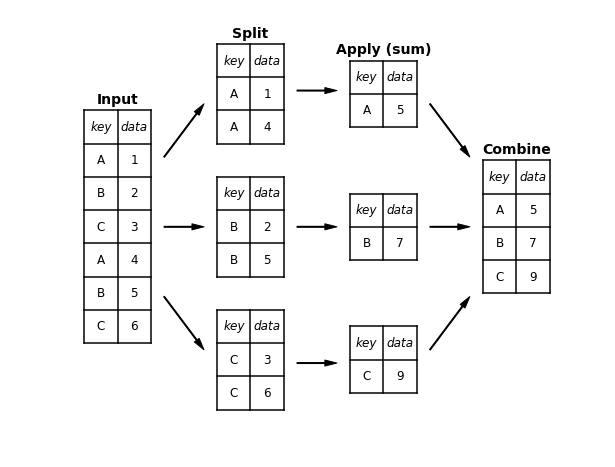

In [12]:
import matplotlib.pyplot as plt
def draw_dataframe(df, loc=None, width=None, ax=None, linestyle=None,
                   textstyle=None):
    loc = loc or [0, 0]
    width = width or 1

    x, y = loc

    if ax is None:
        ax = plt.gca()

    ncols = len(df.columns) + 1
    nrows = len(df.index) + 1

    dx = dy = width / ncols

    if linestyle is None:
        linestyle = {'color':'black'}

    if textstyle is None:
        textstyle = {'size': 12}

    textstyle.update({'ha':'center', 'va':'center'})

    # draw vertical lines
    for i in range(ncols + 1):
        plt.plot(2 * [x + i * dx], [y, y + dy * nrows], **linestyle)

    # draw horizontal lines
    for i in range(nrows + 1):
        plt.plot([x, x + dx * ncols], 2 * [y + i * dy], **linestyle)

    # Create index labels
    for i in range(nrows - 1):
        plt.text(x + 0.5 * dx, y + (i + 0.5) * dy,
                 str(df.index[::-1][i]), **textstyle)

    # Create column labels
    for i in range(ncols - 1):
        plt.text(x + (i + 1.5) * dx, y + (nrows - 0.5) * dy,
                 str(df.columns[i]), style='italic', **textstyle)
        
    # Add index label
    if df.index.name:
        plt.text(x + 0.5 * dx, y + (nrows - 0.5) * dy,
                 str(df.index.name), style='italic', **textstyle)

    # Insert data
    for i in range(nrows - 1):
        for j in range(ncols - 1):
            plt.text(x + (j + 1.5) * dx,
                     y + (i + 0.5) * dy,
                     str(df.values[::-1][i, j]), **textstyle)


#----------------------------------------------------------
# Draw figure

import pandas as pd
df = pd.DataFrame({'data': [1, 2, 3, 4, 5, 6]},
                   index=['A', 'B', 'C', 'A', 'B', 'C'])
df.index.name = 'key'


fig = plt.figure(figsize=(8, 6), facecolor='white')
ax = plt.axes([0, 0, 1, 1])

ax.axis('off')

draw_dataframe(df, [0, 0])

for y, ind in zip([3, 1, -1], 'ABC'):
    split = df[df.index == ind]
    draw_dataframe(split, [2, y])

    sum = pd.DataFrame(split.sum()).T
    sum.index = [ind]
    sum.index.name = 'key'
    sum.columns = ['data']
    draw_dataframe(sum, [4, y + 0.25])
    
result = df.groupby(df.index).sum()
draw_dataframe(result, [6, 0.75])

style = dict(fontsize=14, ha='center', weight='bold')
plt.text(0.5, 3.6, "Input", **style)
plt.text(2.5, 4.6, "Split", **style)
plt.text(4.5, 4.35, "Apply (sum)", **style)
plt.text(6.5, 2.85, "Combine", **style)

arrowprops = dict(facecolor='black', width=1, headwidth=6)
plt.annotate('', (1.8, 3.6), (1.2, 2.8), arrowprops=arrowprops)
plt.annotate('', (1.8, 1.75), (1.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (1.8, -0.1), (1.2, 0.7), arrowprops=arrowprops)

plt.annotate('', (3.8, 3.8), (3.2, 3.8), arrowprops=arrowprops)
plt.annotate('', (3.8, 1.75), (3.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (3.8, -0.3), (3.2, -0.3), arrowprops=arrowprops)

plt.annotate('', (5.8, 2.8), (5.2, 3.6), arrowprops=arrowprops)
plt.annotate('', (5.8, 1.75), (5.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (5.8, 0.7), (5.2, -0.1), arrowprops=arrowprops)
    
plt.axis('equal')
plt.ylim(-1.5, 5);
plt.show()

split step은 specified된 key value를 기준으로 DataFrame을 나누고(beraking up) grouping하는 step이다.
apply step은 individual group 내에서 usaually(일반적으로) aggregate, transformation(변환), fitering 같은 function을 computing한다.
combine step은 이 operation의 results를 output array에 merge한다.

물론 이 작업을 앞에서 다룬 masking, aggregation, merging commnad의 combination을 사용해 직접 수행할 수도 있지만, intermediate splits은 explicitly(명시적으로) 설명할 필요가 없다는 사실을 깨닫는 것이 중요하다. 오히려 GroupBy는 data를 한 번에 처리해 각 group의 sum, mean, count, min을 비롯한 other aggregate를 구할 수 있다. GroupBy의 힘은 이 steps을 abstracts한다는데 있다. 사용자는 이 computation이 내부에서 어떻게 수행되는지에 대해 신경 쓸 필요 없이 전체 차원에서의 operation만 생각하면 된다. 

In [13]:
df = pd.DataFrame({'key' : ['A', 'B', 'C', 'A', 'B', 'C'],
                  'data' : range(6)}, columns = ['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


DataFrame의 groupby() method에 원하는 key column name을 전달해 가장 기본적인 split-apply-combine operation을 compute할 수 있다.

In [14]:
df.groupby('key')

여기서 DataFrame의 set이 아니라 DataFrameGroupBy object가 return된다는데 주목하라. 이 object에는 마법이 존재한다. 이 object는 group을 세부적으로 조사할 만반의 준비는 되어 있으나(be poised to dig), aggregation logic이 적용되기 전까지는 사실상 아무 computation을 하지 않는 DataFrame의 special view로 생각하면 된다. 이 'lazy evaluation' approach는 common aggregate가 user에게 almost transparent(투명한) 방식으로 매우 효율적으로 implement될 수 있음을 의미한다.

aggregate를 이 DataFrameGroupBy object에 apply하면 적절한 apply/combine steps을 perform해 desired result를 produce할 것이다.

In [17]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


sum method는 하나의 예일 뿐이고, 이어지는 내용에서 보듯이 사실상 Pandas나 NumPy의 aggregate를 비롯해 모든 valid(유효한) DataFrame operation을 apply할 수 있다.

## 2) The GroupBy object

GroupBy object는 매우 유연한 abstraction이다. 여러 면에서, 이 object는 simply DataFrame collection처럼 treat(취급하다) 할 수 있으며 내부적으로 어려운 일들을 처리한다. planets data를 사용해 몇 가지 예제를 살펴보자.

GroupBy에서 사용할 수 있는 가장 중요한 operation은 aggregate, filter, transform, apply일 것이다. 각 operaion에 대해 192쪽 'aggregate, filter, transform, apply'에서 자세히 알아보겠지만, 그 전에 basic GroupBy operation과 함께 사용할 수 있는 다른 몇 가지 functionality(기능)를 먼저 살펴보자.


### (1) Column indexing

GroupBy object는 DataFrame과 동일한 방식으로 column indexing을 support하며, modified GroupBy objdect를 return한다. 예를 들면 다음과 같다.

In [18]:
planets.groupby('method')

In [19]:
planets.groupby('method')['orbital_period']

이 예제에서는 column name을 reference해 original DataFrame group으로부터 particular Series group을 select했다. GroupBy object와 마찬가지로 해당 object에서 몇 가지 aggregate를 call하기 전까지는 어떤 computation도 수행되지 않는다.

In [20]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

이 결과를 통해 각 method가 sensitive하게 감지해내는 orbital periods(궤도주기, in days)가 general scale(일반적으로 어느 정도인지) 알 수 있다.


### (2) Iteration over groups

GroupBy object는 group을 direct iteration(직접 순회)할 수 있도록 support하며, each group을 Series나 DataFrame으로 return한다.

In [21]:
for (method, group) in planets.groupby('method') :
    print("{0:30s} shape = {1}".format(method, group.shape))

Astrometry                     shape = (2, 6)
Eclipse Timing Variations      shape = (9, 6)
Imaging                        shape = (38, 6)
Microlensing                   shape = (23, 6)
Orbital Brightness Modulation  shape = (3, 6)
Pulsar Timing                  shape = (5, 6)
Pulsation Timing Variations    shape = (1, 6)
Radial Velocity                shape = (553, 6)
Transit                        shape = (397, 6)
Transit Timing Variations      shape = (4, 6)


이 방법이 특정 작업을 직접 수행할 때는 유용할 수 있지만, 잠시 후에 discuss할 built-in apply fuctionality를 사용하는 것이 대체로 훨씬 더 빠르다.


### (3) Dispatch method

GroupBy object가 explicitly implement하지 않은 method는 그것이 DataFrame object든 Series object든 상관없이 일부 Python class magic을 통해 그 group에 passed되고 called될 것이다. 예를 들면, DataFrmae의 describe() method를 사용해 data의 each group을 describe하는 set of aggregation을 perform할 수 있다.

In [38]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.000000
       Eclipse Timing Variations           9.000000
       Imaging                            38.000000
       Microlensing                       23.000000
       Orbital Brightness Modulation       3.000000
       Pulsar Timing                       5.000000
       Pulsation Timing Variations         1.000000
       Radial Velocity                   553.000000
       Transit                           397.000000
       Transit Timing Variations           4.000000
mean   Astrometry                       2011.500000
       Eclipse Timing Variations        2010.000000
       Imaging                          2009.131579
       Microlensing                     2009.782609
       Orbital Brightness Modulation    2011.666667
       Pulsar Timing                    1998.400000
       Pulsation Timing Variations      2007.000000
       Radial Velocity                  2007.518987
       Transit             

이 표를 보면 data를 더 잘 이해할 수 있다. 예를 들어 대다수의 planets이 Radial Velocity(시선 속도법)과 Transit(통과법)에 의해 발견됐지만, 후자의 방법은 정확성이 향상된 망원경 덕분에 10년 전 쯤에야 보편화됐다. 최신 방법은 2011년까지 새로운 행성을 발견하는 데 사용된 적이 없는 Transit Timing Variations(통과 시점 변화) 및 Orbital Brightness Modulation(궤도 밝기 변조) 방법일 것이다. 

이 예제는 dispatch method utility에 대한 하나의 예시일 뿐이다. dispatch method는 each individual group에 apply되고 그 results는 GrouBy 내에서 결합돼 반환된다는 사실을 알아두자. 다시 말해 모든 valid DataFrame/Series method는 corresponding groupby object에 사용되어 몇 가지 매우 유연하고 강력한 operation을 수행할 수 있다.

## 3) Aggregate, filter, transform, apply

앞에서는 combine operation에서 aggregation에 초점을 맞춰 설명했지만, 그 밖에도 사용할 수 있는 더 많은 option이 있다. 특히 GroupBy object에는 group data를 combining하기 전에 여러 유용한 operation을 효율적으로 impliment하는 aggregate(), filter(), transform(), apply() method가 있다.

다음 DataFrame을 사용해 설명하겠다.

In [32]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key' : ['A', 'B', 'C', 'A', 'B', 'C'],
                  'data1' : range(6),
                  'data2' : rng.randint(0, 10, 6)},
                 columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


### (1) Aggregation

이제 sum(), median() 등을 사용하는 GroupBy aggregation에 익숙해졌지만 aggregate() method가 훨씬 더 많은 flexibility를 제공한다. 이 method는 string, function, list 등을 취해 한번에 모든 aggregate를 compute할 수 있다. 이 모든 것을 combining하는 간단한 예제를 보자.

In [33]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

다른 유용한 pattern은 column name을 해당 column에 적용될 operation에 mapping하는 dictionary를 pass하는 것이다.

In [34]:
df.groupby('key').aggregate({'data1' : 'min', 'data2' : 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


### (2) Filtering

filtering operation을 사용하면 group properties를 기준으로 data를 drop 할 수 있다. 예를 들어, standard deviation이 어떤 critical value(임계값) 보다 큰 group을 모두 유지할 수 있다.

In [35]:
def filter_func(x) :
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

filter() function은 group이 filtering을 pass하는지 아닌지를 specifying(지정하는) boolean value return한다. 여기서는 group A의 standard deviation이 4보다 작으므로 result에서 drop된다.

### (3) Transformation

aggregation은 data의 reduced(축소) version을 return해야 하지만, transformation은 recombine(재결합)을 위해 전체 data의 변환된 version을 retrun 할 수 있다. 그러한 transformation의 경우 output은 항상 input과 같은 shape를 가진다. 일반적인 예로 data에서 group별 mean을 빼서 data를 center에 정렬하는 것을 들 수 있다.

In [39]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


### (4) The apply() method

apply() method는 arbitrary(임의의) functiond을 group result에 apply할 때 사용한다. 이 function은 DataFrame을 취해 Pandas object(즉, DataFrame, Series)나 scalar를 반환한다. combine operation은 return된 output type에 따라 조정된다.(be tailored)

예를 들어, 다음 예제에서 사용한 apply()는 첫 번째 column을 두 번째 column의 sum으로 normalize한다.

In [41]:
def norm_by_data2(x) : 
    # x is a DataFrame of group values(x는 그룹 값을 가지는 DataFrame)
    x['data1'] /= x['data2'].sum()
    return x
display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


GroupBy 내에서 apply()는 상당히 flexible하다. function이 DataFrame을 취하고 Pandas object나 scalar를 return한다는 것이 유일한 criterion이다. 그 중간에 무엇을 하든 상관없다.


## 4) Specifying the split key

앞에서 소개한 간단한 예제에서 하나의 column name을 기준으로 DataFrame을 split했다. 이것은 group을 define하는 여러 option중 하나일 뿐이고, 이제부터 group을 지정하는 다른 option을 살펴보겠다.

### (1) A list, array, series, or index providing the grouping keys

key는 DataFrame의 length와 matching하는 길이의 series나 list일 수 있다.

In [42]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()') 

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

물론 이전의 df.groupby('key')를 accomplishing(달성, 성취)하는데 더 verbose(자세)한 방식이 있다.

In [44]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

### (2) A dictionary or series mapping index to group

또 다른 방법은 index value를 group key에 mapping하는 dictionary를 provide하는 method다.

In [45]:
df2 = df.set_index('key')
mapping = {'A' : 'vowel', 'B' : 'consonant', 'C' : 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


### (3) Any Python function

mapping과 similar하게 index value를 input해서 group을 output하는 Python function을 pass하면 된다.

In [46]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


### (4) A list of vaild keys

앞에서 다룬 모든 key choices 방식은 multi-index에서 group에 combine할 수 있다.

In [48]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


## 5) Grouping example

이에 대한 예제로, Python code 몇 줄에 이 모든 것을 집어넣어 방법 및 연대별로 발견한 planet의 개수를 셀 수 있다.

In [50]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decabe'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decabe,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


이 code는 realistic datasets를 살펴볼 때 지금까지 논의했던 다양한 operation을 combine했을 때의 힘을 보여준다. 지난 수십년 동안 언제 어떻게 planet을 발견했는지에 대해 바로 대략 이해할 수 있다. 이 코드 몇 줄을 자세히 살펴보면서 결과가 나오기까지 정확히 어떤 작업을 하는지 이해하기 위해 단계별로(individual steps) evaluating해볼 것을 권한다. 다소 복잡한 예제인 것은 확실하지만, 이 코드를 이해하고 나면 자신의 data를 비슷하게 explore할 수 있는 방법을 알게 될 것이다.